--- 
<center>

# *PREDICTIVE METHOD: RANDOM FOREST CLASSIFIER* 
by: Ly Nguyen

<center>

In [1]:
# Import necessary libraries for this notebook: 

# Read from SQLite database and load to a pandas dataframe
import os
import sqlite3
import pandas as pd

# For using arrays 
import numpy as np

# For ML work (data preprocessing, hyperparameter tuning, Random Forest Classifier, training & testing sets, and stratified sampling)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# For model evaluation, including explainability:  
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
import statsmodels.api as sm
import shap

# For data visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

# For saving the model into a pkl file
import joblib


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Load the saved df_cleaned parquet file: 
relative_path = os.path.join("..", "data", "df_cleaned.parquet")
df_cleaned = pd.read_parquet(relative_path)


**SETTING TRAINING & TEST SETS** 

In [3]:
# Define X and y: 
X = df_cleaned.drop(columns=['min_delay', 'delayType']) 
y = df_cleaned['delayType']

In [6]:
# As there are ~ 4,400 features, we will need to save the X (predictors) matrix to a .txt file and verify that everything is okay (e.g., features, data types)
# Save column data types to a text file
with open("X_data_types_output.txt", "w") as file:
    file.write(X.dtypes.to_string())

In [5]:

# Split data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Convert y_train to integer if it’s categorical
y_train = y_train.astype(int)

In [11]:
# Save the training set parquet file in 'data' folder (for other ML experimentations)
relative_path = os.path.join("..", "data", "X_train.parquet")
X_train.to_parquet(relative_path, index=False)

relative_path = os.path.join("..", "data", "y_train.csv")
y_train.to_csv(relative_path, index=False)

# Save the test set parquet file in 'data' folder (for other ML experimentations)
relative_path = os.path.join("..", "data", "X_test.parquet")
X_test.to_parquet(relative_path, index=False)

relative_path = os.path.join("..", "data", "y_test.csv")
y_test.to_csv(relative_path, index=False)


**STRATIFIED SAMPLING & PARAMETER TUNING**

As there is a significant class imbalance, we will:
- Set stratified sampling for the training set.
- Set balanced class weight.
- Choose balanced accuracy score as the main scoring metric.

Then we will:
- Manually tune for `max_depth` and the number of trees (`n`).
    - *Note: Although this can be done automatically with Grid Search, manually tuning the parameters allows us to observe how the scoring metric changes with varying parameters.*

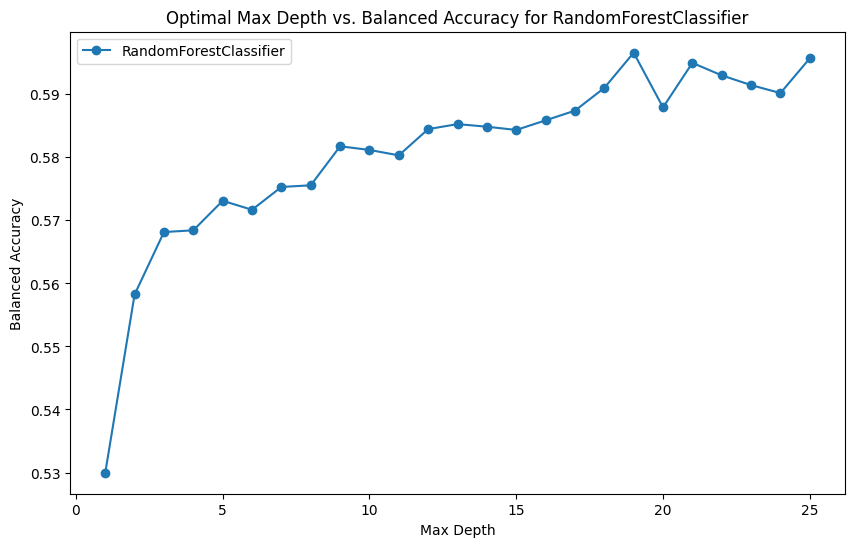

In [12]:
# Set up stratified cross-validation on the training set
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Tune max_depth on the training set using stratified cross-validation
max_depth_range = range(1, 26)
balanced_accuracy_depth = []

for max_depth in max_depth_range:
    rf_temp = RandomForestClassifier(max_depth=max_depth, class_weight='balanced', random_state=42)
    # Perform cross-validation with balanced accuracy scoring
    scores = cross_val_score(rf_temp, X_train, y_train, cv=stratified_cv, scoring='balanced_accuracy')
    mean_score = scores.mean()
    balanced_accuracy_depth.append(mean_score)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, balanced_accuracy_depth, label="RandomForestClassifier", marker='o')
plt.title("Optimal Max Depth vs. Balanced Accuracy for RandomForestClassifier")
plt.xlabel("Max Depth")
plt.ylabel("Balanced Accuracy")
plt.legend()
plt.show()


*Observation:*

- The optimal max_depth is between 18 and 20

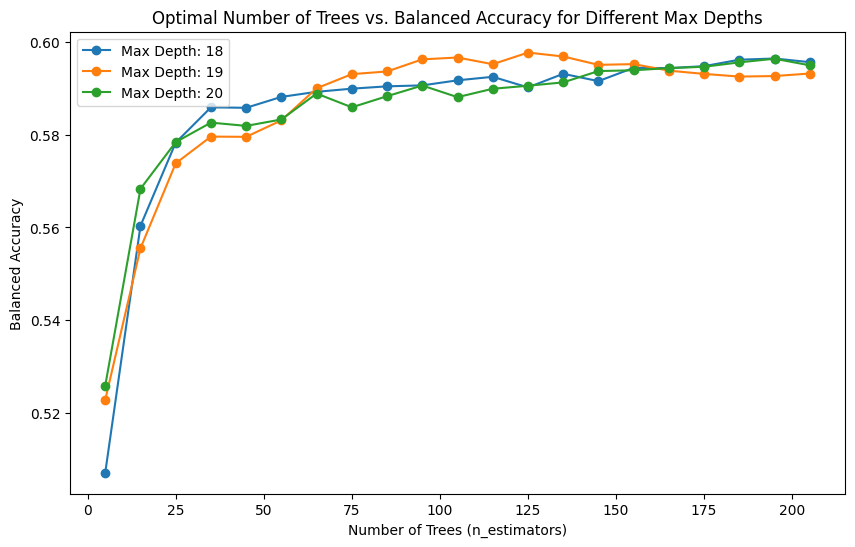

In [13]:
# Tune both max_depth and n_estimators on the training set using stratified cross-validation
max_depth_range = [18, 19, 20]  # Limited max_depth range for faster tuning
n_estimators_range = range(5, 210, 10)  # Range for n_estimators
results = []  # To store results for each combination

for max_depth in max_depth_range:
    balanced_accuracy_scores = []
    for n_estimators in n_estimators_range:
        rf_temp = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight='balanced', random_state=42)
        # Perform cross-validation with balanced accuracy scoring
        scores = cross_val_score(rf_temp, X_train, y_train, cv=stratified_cv, scoring='balanced_accuracy')
        mean_score = scores.mean()
        balanced_accuracy_scores.append(mean_score)
    
    # Store results for this max_depth
    results.append((max_depth, balanced_accuracy_scores))

# Plot the results for each max_depth
plt.figure(figsize=(10, 6))
for max_depth, scores in results:
    plt.plot(n_estimators_range, scores, label=f"Max Depth: {max_depth}", marker='o')

plt.title("Optimal Number of Trees vs. Balanced Accuracy for Different Max Depths")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Balanced Accuracy")
plt.legend()
plt.show()


*Observation:*
- At optimal max_depth of 19, the optimal 'n' number of trees is between 87 and 100, after which there is negligible improvement.

In [14]:
# Define the parameter grid with max_depth fixed at 19
param_grid = {
    'n_estimators': [87, 95, 100],  # Number of trees in the forest
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}


# Initialize the Random Forest Classifier with fixed max_depth
clf = RandomForestClassifier(max_depth=19, class_weight='balanced', random_state=42)

# Initialize StratifiedKFold for stratified cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with StratifiedKFold
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=stratified_cv,
    scoring='balanced_accuracy',
    n_jobs=-1
)


# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)


Best parameters found:  {'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 87}


In [6]:
best_params = {
    'min_samples_leaf': 1,  # Minimum number of samples required to be at a leaf node
    'min_samples_split': 5,  # Minimum number of samples required to split an internal node
    'n_estimators': 87,  # Number of trees in the forest
     'max_depth': 19  # Minimum number of samples required to split an internal node
}

# Initialize and fit the Random Forest Classifier with updated best parameters
best_clf = RandomForestClassifier(**best_params, class_weight='balanced', random_state=42)
best_clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=19,
                       min_samples_split=5, n_estimators=87, random_state=42)

In [7]:
# Fit the model on the test set
y_pred = best_clf.predict(X_test)



In [8]:
# Get the feature importances
feature_importances = best_clf.feature_importances_

# Use the feature names from the preprocessed data
features = X.columns  # Get all the feature names from the DataFrame after preprocessing

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


                                Feature  Importance
4371                           line_512    0.135904
2823                 incident_Diversion    0.083244
2829                incident_Mechanical    0.052561
4365                           line_506    0.033095
2822  incident_Collision - TTC Involved    0.019920
...                                 ...         ...
881      location_DUNDAS WEST AND HURON    0.000000
2377      location_SPADINA AND COLLEGE`    0.000000
880     location_DUNDAS WEST AND HOWARE    0.000000
2379     location_SPADINA AND ELDERWOOD    0.000000
0                 location_1 DAVIES AVE    0.000000

[4390 rows x 2 columns]


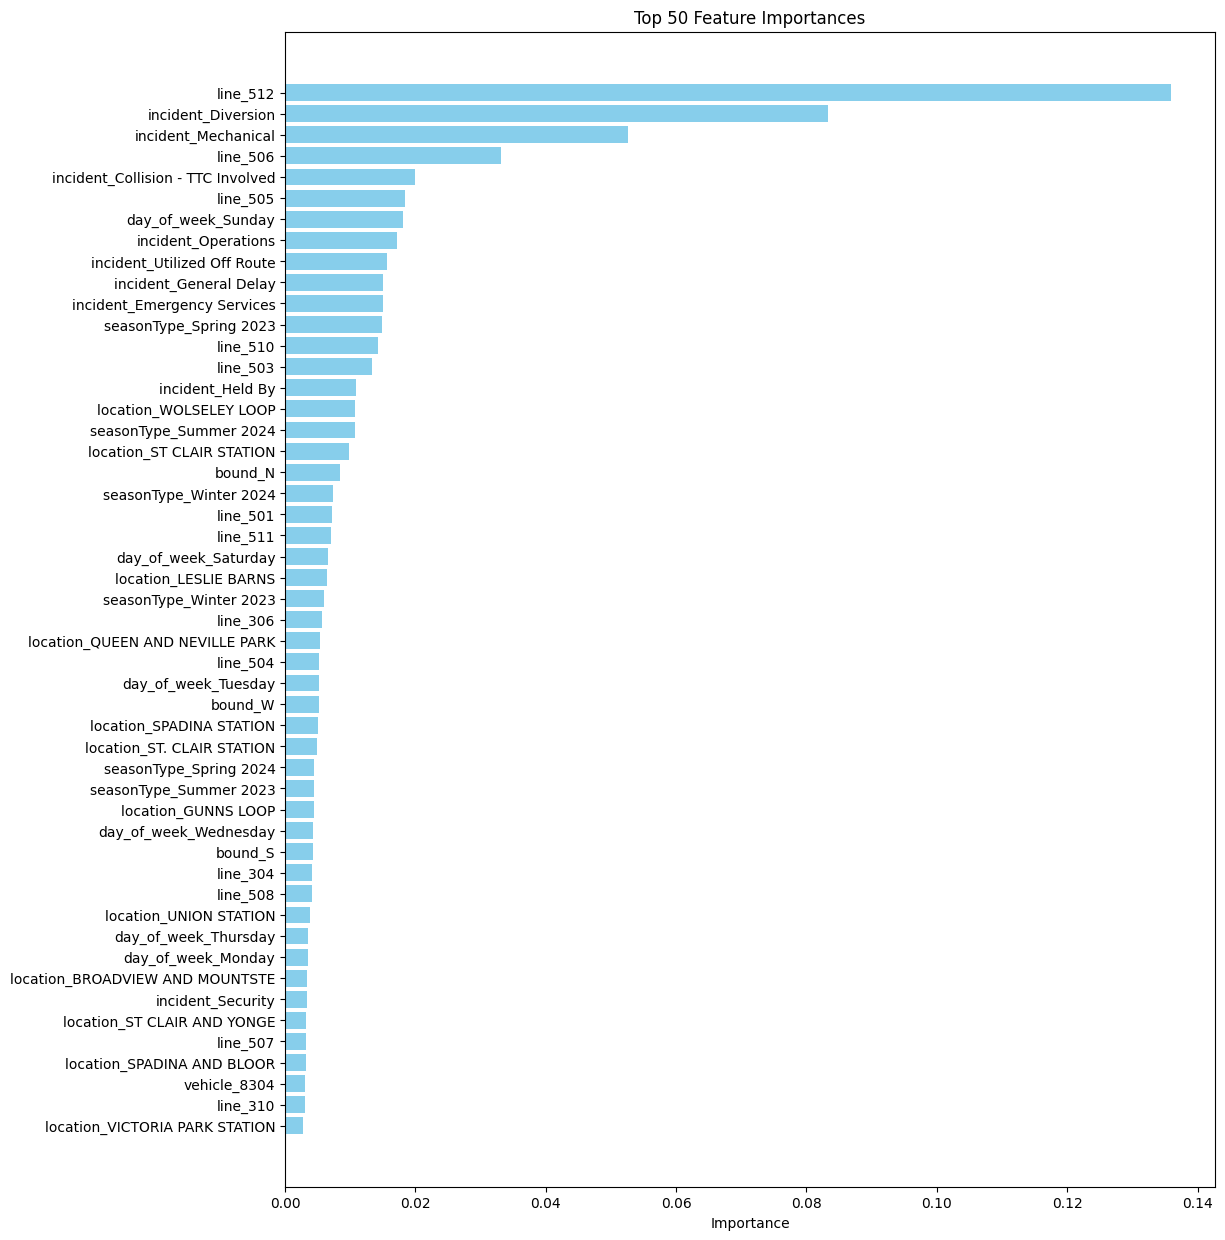

In [9]:
# Select the top 50 features
top_50_features = importance_df.head(50)

# Plot the top 200 feature importances
plt.figure(figsize=(12, 15))
plt.barh(top_50_features['Feature'], top_50_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 50 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


In [11]:
# Convert the 'Feature' column to a list
top_50_features_list = top_50_features['Feature'].tolist()


In [17]:
# Ensure the target column is added to the top 50 features
reduced_features = top_50_features_list + ['delayType']

# Subset the cleaned dataset
df_reduced = df_cleaned[reduced_features]


In [ ]:
# Save the top 50 features as a CSV file
relative_path = os.path.join("..", "data", "top_50_features.csv")
top_50_features.to_csv(relative_path, index=False) # Save the top 50 features without the index column

In [19]:
# Save the reduced dataset for Dimensionality Reduction studies
relative_path = os.path.join("..", "data", "df_reduced.parquet")
df_reduced.to_parquet('df_reduced.parquet', index=False)


---
# *MODEL PERFORMANCE EVALUATION*

In [22]:
# Generate the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Calculate and print the balanced accuracy score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy: {balanced_acc:.2f}")


Classification Report:
               precision    recall  f1-score   support

           1       0.34      0.61      0.43       583
           2       0.83      0.56      0.67      3832
           3       0.37      0.63      0.46      1056

    accuracy                           0.58      5471
   macro avg       0.51      0.60      0.52      5471
weighted avg       0.69      0.58      0.60      5471


Balanced Accuracy: 0.60


### **INTERPRETATION:**

- **Balanced Accuracy:** The model performs above average, with **60%** of the predictions made by the model are correct. 

- **Precision, Recall, and F1-score (ie. the harmonic mean of precision and recall):** 
    
    - **Precision scores**: 
    
        - The model performs poorly for the minority classes: 34% for the Delay Type 1 (short delays <=5 minutes>), and 37% for  the Delay Type 3 (long delays >=16 minutes)
        
        - However, the model performs well for the majority class - 83% for the Delay Type 2 (normal delays, between 6 and 15 minutes). 
        
        - This means that there are many false positives for the minority classes (Delay Types 1 and 3). 

    - **Recall scores**: Above average scores across the classes (61%, 56% and 63% for Delay Type 1, 2 and 3 respectively). This means there are many missed true positive cases. 
       
    - **F1 scores**: Poor scores for the minority classes - 43% for the Delay Type 1, and 46% for  the Delay Type 3 -  but performs acceptably for the majority class - 67% for the Delay Type 2. This means that the model is not effective at correctly identifying positive instances while minimizing false positives - especially for the minority classes. 




## SHAP (Explainability)

In [23]:
# Create a SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(best_clf)

# Calculate SHAP values
# For classifiers, shap_values is a list of arrays (one per class)
shap_values = explainer.shap_values(X_test)


In [24]:
# SHAP values for delayType = 1
shap_values_class1 = shap_values[0]

# SHAP values for delayType = 2
shap_values_class2 = shap_values[1]

# SHAP values for delayType = 3
shap_values_class3 = shap_values[2]


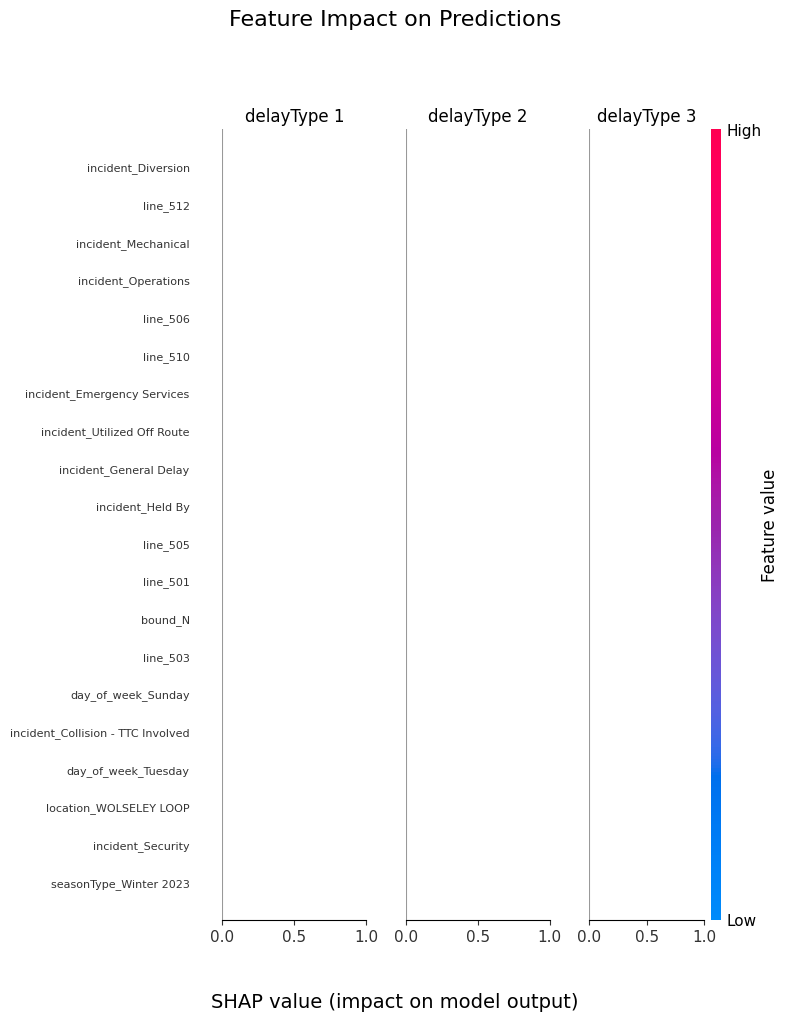

In [25]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)  # 1 row, 3 columns

# Beeswarm plot for delayType = 1
plt.sca(axes[0])  # Set the current axis to the first subplot
shap.summary_plot(shap_values_class1, X_test, plot_type="beeswarm", show=False, color_bar=False)  # Hide color bar
axes[0].set_title("delayType 1", fontsize=12)
axes[0].tick_params(axis='y', labelsize=8)  # Make Y-axis fonts smaller
axes[0].set_xlabel("")  # Remove X-axis label

# Beeswarm plot for delayType = 2
plt.sca(axes[1])  # Set the current axis to the second subplot
shap.summary_plot(shap_values_class2, X_test, plot_type="beeswarm", show=False, color_bar=False)  # Hide color bar
axes[1].set_title("delayType 2", fontsize=12)
axes[1].tick_params(axis='y', labelsize=8)  # Make Y-axis fonts smaller
axes[1].set_xlabel("")  # Remove X-axis label

# Beeswarm plot for delayType = 3
plt.sca(axes[2])  # Set the current axis to the third subplot
shap.summary_plot(shap_values_class3, X_test, plot_type="beeswarm", show=False)  # Keep color bar
axes[2].set_title("delayType 3", fontsize=12)
axes[2].tick_params(axis='y', labelsize=8)  # Make Y-axis fonts smaller
axes[2].set_xlabel("")  # Remove X-axis label

# Add a centered title above all subplots
fig.suptitle("Feature Impact on Predictions", fontsize=16, y=1)  # Adjust y for better spacing

# Add a single label below the x-axes
fig.text(0.5, -0.05, "SHAP value (impact on model output)", ha='center', fontsize=14)

# Adjust layout for better readability
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to leave space for the suptitle
plt.show()


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


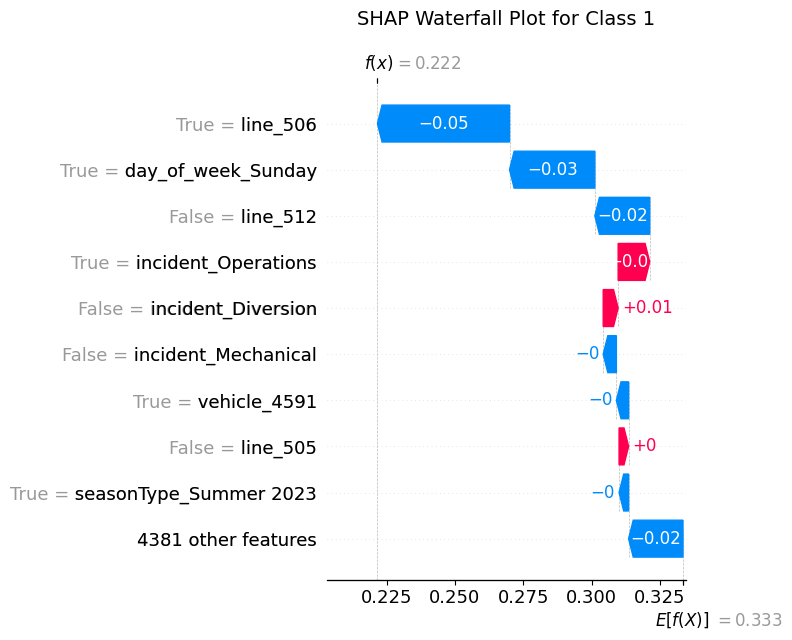

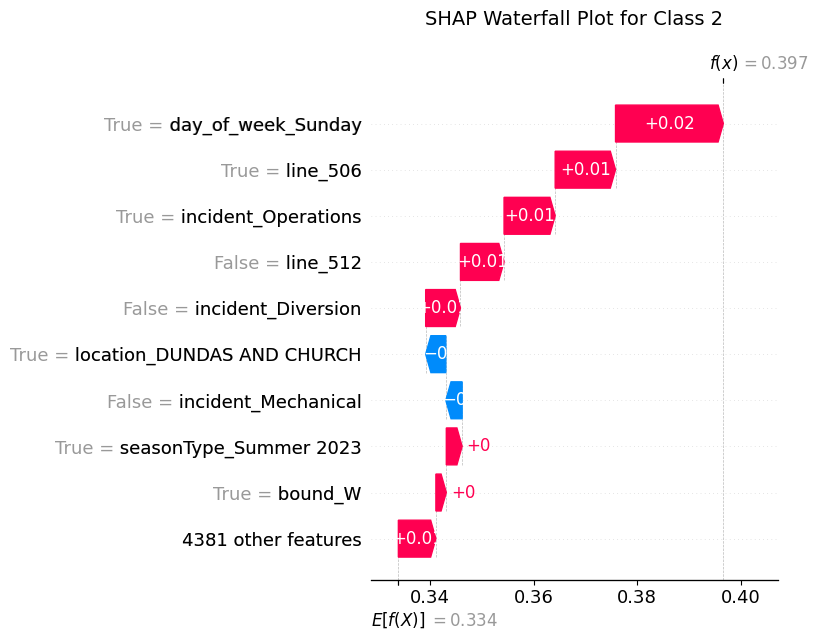

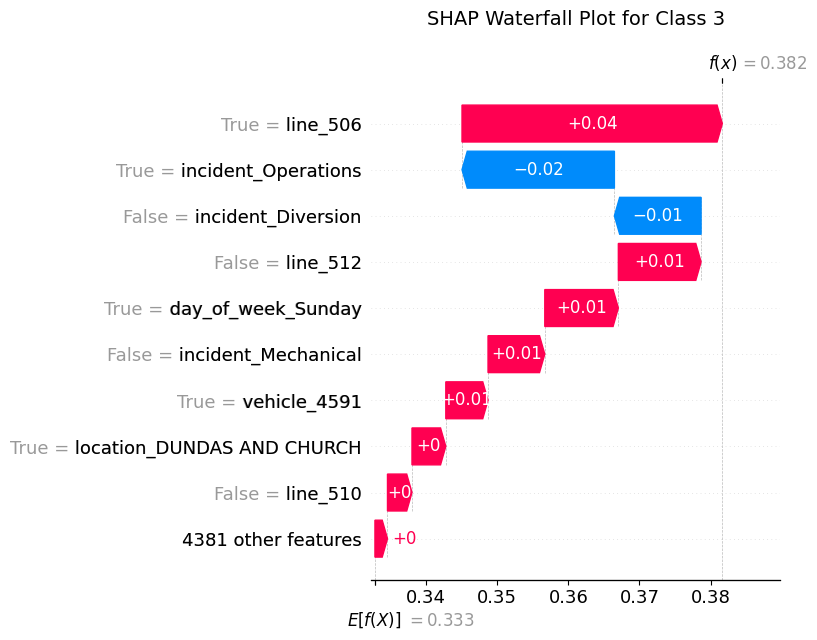

In [26]:
# Sample index for demonstration
sample_index = 0

# Store shap values for the 3 classes in a list of arrays
shap_values_list = [shap_values_class1, shap_values_class2, shap_values_class3]

# Iterate through each class to create waterfall plots
for i in range(len(shap_values_list)):
    shap_values_class = shap_values_list[i]
    
    # Create SHAP explanation object for the current class
    explanation = shap.Explanation(
        values=shap_values_class[sample_index],
        base_values=explainer.expected_value[i],  # Base value for the current class
        data=X_test.iloc[sample_index],
        feature_names=X_test.columns
    )
    
    # Generate the waterfall plot with a title directly inside the plot
    plt.figure(figsize=(8, 6))  # Optional: Set figure size
    shap.waterfall_plot(explanation, max_display=10, show=False)
    plt.title(f"SHAP Waterfall Plot for Class {i+1}", fontsize=14, pad=20)  # Add a title to the plot
    plt.tight_layout()  # Ensure layout fits well
    plt.show()  # Display the plot


### **INTERPRETATION:**

#### **Delay Type 1:**
- The final predicted value is **0.222**, lower than the baseline (0.333).

- Positive influential features:
  - Incident types Operations and Diversion: Improve the prediction by +0.02 and +0.01 respectively.

- Negative influential features:
  - Lines 506 and 512: Reduce the prediction by -0.05 and -0.02 respectively.
  - Sunday: Reduces the prediction by -0.03. 



#### **Delay Type 2:**
- The final predicted value is **0.397**, similar to baseline (0.334)

- Positive influential features:
  - Sunday: Improves the prediction by +0.02. 
  - Lines 506 and 512: Improves the prediction by +0.01 each.
  - Incident types Operations and Diverson: Improve the prediction by +0.01 each. 
  


#### **Delay Type 3:**
- The final predicted value is **0.382**, similar to the baseline (0.333).

- Positive influential features:
  - Lines 506 and 512: Improve the prediction by +0.04 and +0.01 respectively.
  - Sunday: Improves the prediction by +0.01.  
  - Incident Mechanical: Improves the prediction by +0.01. 
  - Vehicle 4591: Improves the prediction by +0.01

- Negative influential features:
  - Incident types Operations and Diversion: Reduce the prediction by -0.02 and -0.01 respectively.
 


## Patterns and Observations:

- **Incident types Operations and Diversion**
   - Improves prediction for Delay Types 1 and 2. 
   - Reduces prediction for Delay Type 3.

- **Lines 506 and 512**, and **Sunday**:  
   - Improves prediction for Delay Types 2 and 3.
   - Reduces prediction for Delay Type 1.

- **Vehicle 4591** and **Incident Mechanical**:   
   - Improves prediction for Delay Type 3.


### Next actions:
- Analyze features like **line_506** and **day_of_week_Sunday** further, as they significantly influence predictions.
- Reduce dimensionality (remove low-impact features) to improve speed.


---
# *Descriptive Statistics - Mosaic Plot*

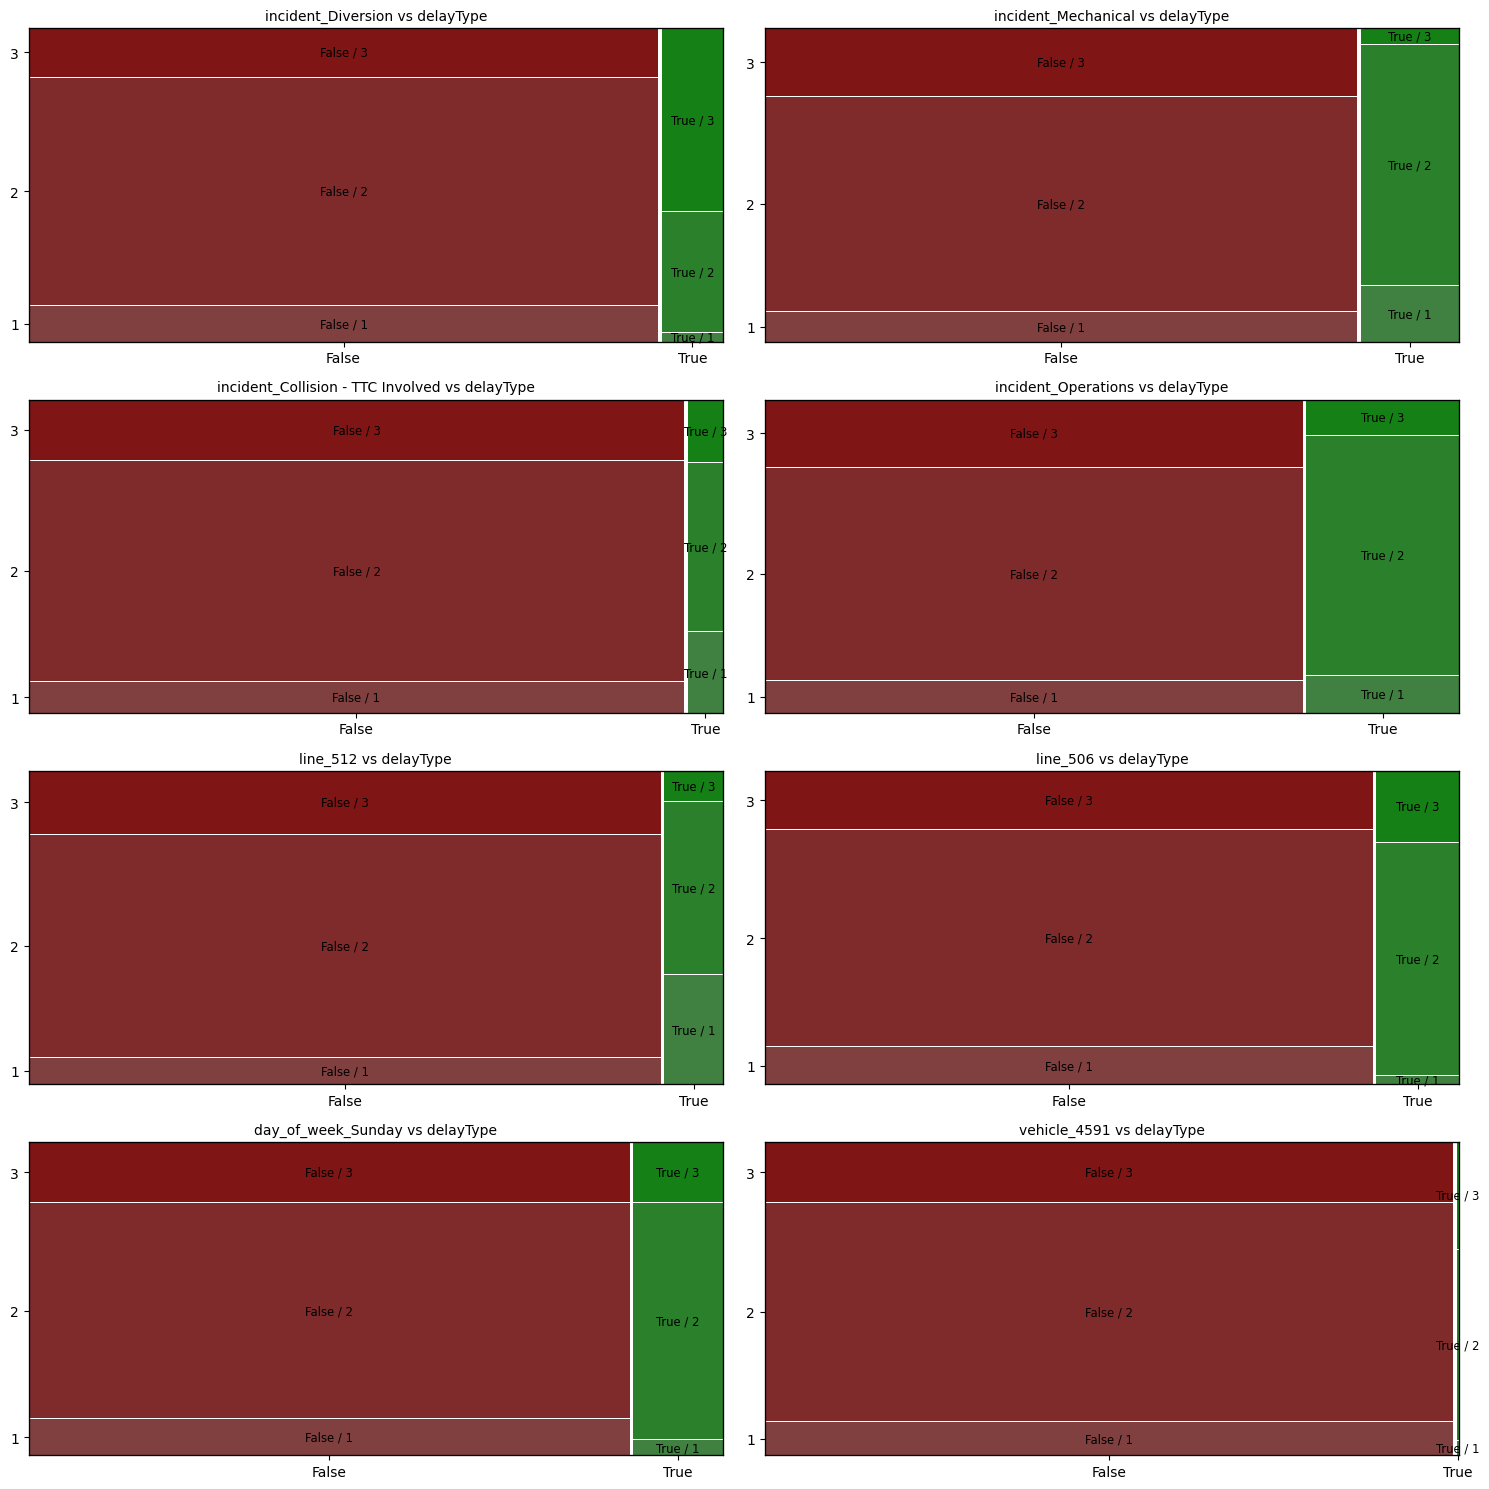

In [35]:
# Load dataset for mosaic plot
mosaic_df = df_cleaned.copy()

# List of features to plot against delayType
features_mosaic = [
    "incident_Diversion", "incident_Mechanical", "incident_Collision - TTC Involved",
    "incident_Operations", "line_512", "line_506", "day_of_week_Sunday", "vehicle_4591"
]

# Create a grid of subplots (4 rows x 2 columns for 8 plots)
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Generate mosaic plots for each feature
for i, feature_mosaic in enumerate(features_mosaic):
    ax = axes[i]
    try:
        # Create a cross-tabulation
        cross_tab = pd.crosstab(mosaic_df[feature_mosaic], mosaic_df['delayType'])
        
        # Generate the mosaic plot
        mosaic(cross_tab.stack(), ax=ax, labelizer=lambda k: f"{k[0]} / {k[1]}")
        
        # Add a title to each subplot
        ax.set_title(f'{feature_mosaic} vs delayType', fontsize=10)
    except Exception as e:
        ax.set_title(f'Error with {feature_mosaic}', fontsize=10)
        print(f"Error generating plot for {feature_mosaic}: {e}")

# Remove any unused subplots if features < number of subplots
for j in range(len(features_mosaic), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Interpretation:

#### **Incident Diversion** and **line 506**:
- The majority of the delays aren't related to these features. 
- However, when a delay involves any of them, long delays (16 minutes or more) are more prevalent.  


#### **Incident types Mechanical**, **Collision - TTC Involved**, and **Line 512**:
- The majority of the delays aren't related to these features.
- However, when a delay involves any of them, short delays (5 minutes or less) are more prevalent.


#### **Incident Operations**:
- Incident Operations is involved in delays more than other features.


#### **Sunday**
- The majority of the delays don't fall on a Sunday.
- However, when a delay falls on a Sunday, normal delays (between 6 and 15 minutes) are more prevalent.

#### **Vehicle 4591**
- 99% of the time a delay is not related to vehicle 4591.

---